Epoch 1/10


c:\Users\ansl6\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7826 - val_loss: 0.1097
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2568 - val_loss: 0.0154
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0048
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - val_loss: 0.0031
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0020
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


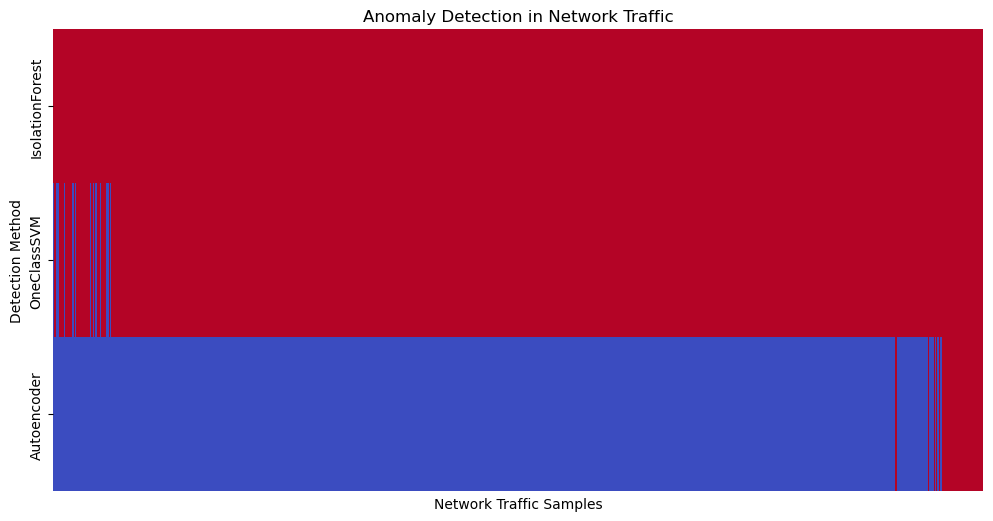

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense

# Load Network Traffic Dataset
# Ensure your dataset has only numerical features for ML models.
df = pd.read_csv("bigdata.csv")

# Feature Selection (Remove non-numeric columns like 'timestamp', 'protocol')
df = df.select_dtypes(include=['float64', 'int64'])

# Standardize Data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Split Data (80% Normal, 20% for Anomaly Injection)
train_size = int(0.8 * len(df_scaled))
X_train = df_scaled[:train_size]
X_test = df_scaled[train_size:]

### --- 1. Isolation Forest ---
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X_train)
iso_preds = iso_forest.predict(X_test)

# Convert (-1 = anomaly, 1 = normal) to (1 = anomaly, 0 = normal)
iso_anomalies = np.where(iso_preds == -1, 1, 0)

### --- 2. One-Class SVM ---
oc_svm = OneClassSVM(nu=0.05, kernel="rbf")
oc_svm.fit(X_train)
oc_preds = oc_svm.predict(X_test)

# Convert (-1 = anomaly, 1 = normal) to (1 = anomaly, 0 = normal)
oc_anomalies = np.where(oc_preds == -1, 1, 0)

### --- 3. Autoencoder for Anomaly Detection ---
input_dim = X_train.shape[1]

# Build Autoencoder Model
autoencoder = keras.Sequential([
    Dense(32, activation='relu', input_shape=(input_dim,)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder (Only on normal data)
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_train, X_train), verbose=1)

# Compute Reconstruction Loss
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test - X_test_reconstructed), axis=1)

# Set threshold for anomalies
threshold = np.percentile(reconstruction_error, 95)
autoencoder_anomalies = (reconstruction_error > threshold).astype(int)

### --- Visualizing Results ---
results = pd.DataFrame({
    "IsolationForest": iso_anomalies,
    "OneClassSVM": oc_anomalies,
    "Autoencoder": autoencoder_anomalies
})

# Plot anomaly detection results
plt.figure(figsize=(12, 6))
sns.heatmap(results.T, cmap="coolwarm", cbar=False, xticklabels=False)
plt.xlabel("Network Traffic Samples")
plt.ylabel("Detection Method")
plt.title("Anomaly Detection in Network Traffic")
plt.show()


In [3]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tensorflow import keras
from tensorflow.keras.layers import Dense

# Load Wireshark CSV Data
df = pd.read_csv("bigdata.csv")

# Normalize time to start from zero
df['Time'] = df['Time'] - df['Time'].min()

# Select only numerical features
df_numeric = df.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

time_values = df['Time'].values  # Extract time for plotting

# Store original dataset values for hover info
df_test_original = df.iloc[int(0.8 * len(df)):]

# Split Data for Training
df_train = df_scaled[:int(0.8 * len(df_scaled))]
df_test = df_scaled[int(0.8 * len(df_scaled)):]  # 20% for testing

def detect_anomalies():
    # Isolation Forest
    iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    iso_forest.fit(df_train)
    iso_preds = iso_forest.predict(df_test)
    iso_anomalies = np.where(iso_preds == -1, 1, 0)

    # One-Class SVM
    oc_svm = OneClassSVM(nu=0.05, kernel="rbf")
    oc_svm.fit(df_train)
    oc_preds = oc_svm.predict(df_test)
    oc_anomalies = np.where(oc_preds == -1, 1, 0)

    # Autoencoder
    input_dim = df_train.shape[1]
    autoencoder = keras.Sequential([
        Dense(32, activation='relu', input_shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),
        Dense(input_dim, activation='linear')
    ])
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(df_train, df_train, epochs=10, batch_size=32, verbose=0)
    
    reconstructions = autoencoder.predict(df_test)
    reconstruction_error = np.mean(np.abs(df_test - reconstructions), axis=1)
    threshold = np.percentile(reconstruction_error, 95)
    autoencoder_anomalies = (reconstruction_error > threshold).astype(int)

    # Combine results to detect the final anomalies
    final_anomalies = (iso_anomalies + oc_anomalies + autoencoder_anomalies) >= 2  # Majority voting
    
    return time_values[len(df_train):], reconstruction_error, final_anomalies, iso_anomalies, oc_anomalies, autoencoder_anomalies

# Run Anomaly Detection
time_test, anomaly_scores, anomalies, iso_flags, oc_flags, auto_flags = detect_anomalies()

# Identify Anomalies & Their Corresponding Values
anomaly_indices = np.where(anomalies == 1)[0]  # Indices of anomalies in the test set
anomaly_times = time_test[anomaly_indices]  # Ensure this corresponds to anomaly indices in the test set
anomaly_scores_values = anomaly_scores[anomaly_indices]  # Similarly, align the scores with the anomalies

# Generate reason for anomaly detection
def get_anomaly_reason(idx):
    reasons = []
    if iso_flags[idx] == 1:
        reasons.append("Isolation Forest detected unusual behavior.")
    if oc_flags[idx] == 1:
        reasons.append("One-Class SVM flagged deviation.")
    if auto_flags[idx] == 1:
        reasons.append("Autoencoder reconstruction error too high.")
    
    return "<br>".join(reasons) if reasons else "Normal behavior."

# Create hover text ONLY for anomalies with detailed reasons
hover_texts_anomalies = [
    f"Time: {anomaly_times[i]}<br><b>Score:</b> {anomaly_scores_values[i]}<br><b>Reason:</b> {get_anomaly_reason(anomaly_indices[i])}"
    for i in range(len(anomaly_indices))
]

# Interactive 2D Straight-Line Graph
fig = go.Figure()

# Normal Data Line (Blue, No Details)
fig.add_trace(go.Scatter(
    x=time_test, y=anomaly_scores, mode='lines',
    line=dict(color='blue', width=2),
    name='Normal Data'
))

# Anomalies Marked in Red (Hover shows details + reason)
fig.add_trace(go.Scatter(
    x=anomaly_times, y=anomaly_scores_values, mode='markers',
    marker=dict(size=8, color='red'),
    name='Anomalies',
    hovertext=hover_texts_anomalies,
    hoverinfo="text"  # Shows reason, score, and time on hover
))

# Layout Settings for Zoom & Hover
fig.update_layout(
    title="Anomaly Detection",
    xaxis_title="Time (seconds)",
    yaxis_title="Anomaly Score",
    hovermode="x",
    template="plotly_dark",
    dragmode="pan"  # Allows zooming and panning
)

# Show Interactive Plot
fig.show()


c:\Users\ansl6\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [4]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from tensorflow import keras
from tensorflow.keras.layers import Dense

# Load Wireshark CSV Data
df = pd.read_csv("bigdata.csv")

# Normalize time to start from zero
df['Time'] = df['Time'] - df['Time'].min()

# Select only numerical features
df_numeric = df.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

time_values = df['Time'].values  # Extract time for plotting

# Store original dataset values for hover info
df_test_original = df.iloc[int(0.8 * len(df)):]

# Split Data for Training
df_train = df_scaled[:int(0.8 * len(df_scaled))]
df_test = df_scaled[int(0.8 * len(df_scaled)):]  # 20% for testing

def detect_anomalies():
    # Isolation Forest
    iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    iso_forest.fit(df_train)
    iso_preds = iso_forest.predict(df_test)
    iso_anomalies = np.where(iso_preds == -1, 1, 0)

    # One-Class SVM
    oc_svm = OneClassSVM(nu=0.05, kernel="rbf")
    oc_svm.fit(df_train)
    oc_preds = oc_svm.predict(df_test)
    oc_anomalies = np.where(oc_preds == -1, 1, 0)

    # K-Means Clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(df_train)
    kmeans_preds = kmeans.predict(df_test)
    kmeans_anomalies = np.where(kmeans_preds == 1, 1, 0)  # Assuming cluster 1 is anomaly

    # Autoencoder
    input_dim = df_train.shape[1]
    autoencoder = keras.Sequential([
        Dense(32, activation='relu', input_shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),
        Dense(input_dim, activation='linear')
    ])
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(df_train, df_train, epochs=10, batch_size=32, verbose=0)
    
    reconstructions = autoencoder.predict(df_test)
    reconstruction_error = np.mean(np.abs(df_test - reconstructions), axis=1)
    threshold = np.percentile(reconstruction_error, 95)
    autoencoder_anomalies = (reconstruction_error > threshold).astype(int)

    # Combine results to detect the final anomalies
    final_anomalies = (iso_anomalies + oc_anomalies + kmeans_anomalies + autoencoder_anomalies) >= 2  # Majority voting
    
    return time_values[len(df_train):], reconstruction_error, final_anomalies, iso_anomalies, oc_anomalies, kmeans_anomalies, autoencoder_anomalies

# Run Anomaly Detection
time_test, anomaly_scores, anomalies, iso_flags, oc_flags, kmeans_flags, auto_flags = detect_anomalies()

# Identify Anomalies & Their Corresponding Values
anomaly_indices = np.where(anomalies == 1)[0]
anomaly_times = time_test[anomaly_indices]
anomaly_scores_values = anomaly_scores[anomaly_indices]

# Generate reason for anomaly detection
def get_anomaly_reason(idx):
    reasons = []
    if iso_flags[idx] == 1:
        reasons.append("Isolation Forest detected unusual behavior.")
    if oc_flags[idx] == 1:
        reasons.append("One-Class SVM flagged deviation.")
    if kmeans_flags[idx] == 1:
        reasons.append("K-Means clustering detected anomaly.")
    if auto_flags[idx] == 1:
        reasons.append("Autoencoder reconstruction error too high.")
    
    return "<br>".join(reasons) if reasons else "Normal behavior."

# Create hover text ONLY for anomalies
hover_texts_anomalies = [f"{df_test_original.iloc[i].to_json()}<br><b>Reason:</b> {get_anomaly_reason(i)}" for i in anomaly_indices]

# Create a function to plot individual anomaly detection results
def create_anomaly_plot(time_test, anomaly_scores, anomaly_times, anomaly_scores_values, hover_texts_anomalies, anomalies, technique_name, anomaly_flags):
    fig = go.Figure()

    # Normal Data Line (Blue, No Details)
    fig.add_trace(go.Scatter(
        x=time_test, y=anomaly_scores, mode='lines',
        line=dict(color='blue', width=2),
        name='Normal Data'
    ))

    # Anomalies Marked in Red (Hover shows details + reason)
    anomaly_indices = np.where(anomaly_flags == 1)[0]
    anomaly_times = time_test[anomaly_indices]
    anomaly_scores_values = anomaly_scores[anomaly_indices]
    
    fig.add_trace(go.Scatter(
        x=anomaly_times, y=anomaly_scores_values, mode='markers',
        marker=dict(size=8, color='red'),
        name=f'{technique_name} Anomalies',
        hovertext=hover_texts_anomalies,
        hoverinfo="text"  # Shows reason only on hover
    ))

    # Layout Settings for Zoom & Hover
    fig.update_layout(
        title=f"{technique_name} - Anomaly Detection",
        xaxis_title="Time (seconds)",
        yaxis_title="Anomaly Score",
        hovermode="x",
        template="plotly_dark",
        dragmode="pan"  # Allows zooming and panning
    )

    return fig

# Combined Plot
fig_combined = go.Figure()

# Plot Combined Anomalies
fig_combined.add_trace(go.Scatter(
    x=time_test, y=anomaly_scores, mode='lines',
    line=dict(color='blue', width=2),
    name='Normal Data'
))

# Anomalies Marked in Red (Hover shows details + reason)
fig_combined.add_trace(go.Scatter(
    x=anomaly_times, y=anomaly_scores_values, mode='markers',
    marker=dict(size=8, color='red'),
    name='Combined Anomalies',
    hovertext=hover_texts_anomalies,
    hoverinfo="text"  # Shows reason only on hover
))

# Layout for Combined Plot
fig_combined.update_layout(
    title="Combined Anomaly Detection",
    xaxis_title="Time (seconds)",
    yaxis_title="Anomaly Score",
    hovermode="x",
    template="plotly_dark",
    dragmode="pan"  # Allows zooming and panning
)

# Show Combined Plot
fig_combined.show()

# Plot Individual Anomalies for each technique
fig_iso = create_anomaly_plot(time_test, anomaly_scores, anomaly_times, anomaly_scores_values, hover_texts_anomalies, anomalies, "Isolation Forest", iso_flags)
fig_oc = create_anomaly_plot(time_test, anomaly_scores, anomaly_times, anomaly_scores_values, hover_texts_anomalies, anomalies, "One-Class SVM", oc_flags)
fig_kmeans = create_anomaly_plot(time_test, anomaly_scores, anomaly_times, anomaly_scores_values, hover_texts_anomalies, anomalies, "K-Means", kmeans_flags)
fig_auto = create_anomaly_plot(time_test, anomaly_scores, anomaly_times, anomaly_scores_values, hover_texts_anomalies, anomalies, "Autoencoder", auto_flags)

# Show Individual Plots
fig_iso.show()
fig_oc.show()
fig_kmeans.show()
fig_auto.show()


c:\Users\ansl6\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
